# Guide 2. Loading and plotting bulk statistics - Deployment 1

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of bulk statistics (wave and current velocities) for data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in the series: it summarizes the methods used for calculating bulk statistics and provides a comparison against local wave buoy data. It also summarizes Deployment 1, including the location of the sensors and general climatological conditions.

**Deployment 1: August 20 - September 19, 2024** 

On the day of sensor deployment, there were peak wave heights of ~2.5-3 ft with periods of ~5 seconds coming from the South. The wind was ~8-10 knots, with ~10-15 knot gusts coming from the North East. The air temperature was 78 degrees Fahrenheit. 

Five ADCPs were deployed during Deployment 1: two by NCSU (S0 and S1, both on the south-side of Frying Pan Shoals) and three by UNCW (C0, E0, and E1). The ADCPs were secured upward-facing onto landers, which are 2x2x3ft steel frames that were lowered to the sea floor and oriented so their internal compass axes align with the local magnetic declination (~9.5° W). ADCPs were 2 feet off the seafloor. The latitude and longitude of all five sensors' deployment locations are provided in the table below. Upon recovery, both S0 and S1 were free of debris and sediment. Notably, C0 was not recovered on September 19th due to the complete burial of the lander. It was later recovered during Deployment 2. Average water depth was around 30-40 feet.

| ADCP   | Latitude | Longitude
| -------| ------------ | ------------ 
| S0 | 33°43.7167 | 77°56.5024
| S1 | 33°47.4866 | 77°59.0869
| C0 | 33°39.6334 | 77°53.4570
| S1 | 33°44.1425 | 77°54.2064
| C0 | 33°48.1873 | 77°55.9085

*Meteorlogical and oceanographic conditions*: On September 13th, Potential Tropical Cyclone Eight developed off the North Carolina coast and continued to move inland until September 16, 2024. This storm produced record-breaking rainfalls, including 12-20 inches of rainfall over two days in the Wilmington region. It also produced significant wave action (discussed below) regionally. Two perigean spring tides occurred during the study period, spanning August 17 to August 26th and September 15 to September 23.

**Storage**

The bulk statistics are stored in h5 files, like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks.' Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the waves we can observe, a shorter window and we may miss out on some longer period waves.

In [13]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

dirpath = r'Z:\deployment_1\BulkStats\S0_103080'
#dirpath=r"/Volumes/kanarde/BOEM/deployment_1/BulkStats/S0_103080" #brooke path

files = os.listdir(dirpath) # list of files in Group 1

waves = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    waves[file_name] = df  # store dataframe

GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVeloctiy
DepthAveragedNorthVeloctiy
MeanDirection1
MeaanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDireciton
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
MeanSpread1


**Time**

The time data field stores the datetime assoicated with each chunk. It should be roughly evenly spaced one hour apart.

                             0
0   2024-09-17 11:30:00.126107
1   2024-09-17 12:30:00.126104
2   2024-09-17 13:30:00.126111
3   2024-09-17 14:30:00.126107
4   2024-09-17 15:30:00.126104
..                         ...
763 2024-08-23 06:30:00.126104
764 2024-08-23 07:30:00.126111
765 2024-08-23 08:30:00.126107
766 2024-08-23 09:30:00.126104
767 2024-08-23 10:30:00.126111

[768 rows x 1 columns]


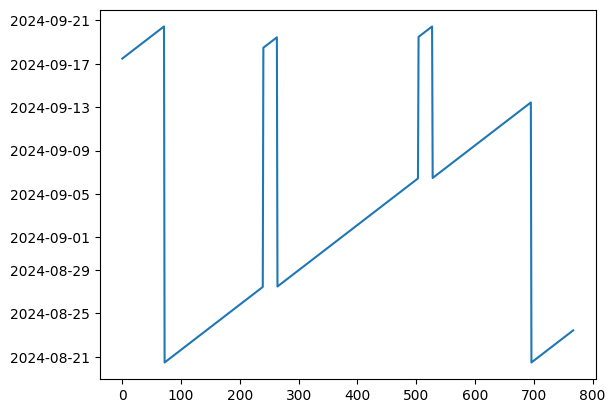

In [14]:
print(waves['Time'])
plt.plot(waves['Time'])


In [11]:
#Function to convert unix timestamp in ns to regular datetime in UTC
def unix_ns_to_datetime(unix_ns_array):
    dates = []
    for date in unix_ns_array:
        seconds = date // 1_000_000_000
        nanoseconds = date % 1_000_000_000
        python_datetime = datetime.datetime.utcfromtimestamp(seconds) + datetime.timedelta(microseconds=nanoseconds / 1000)
        dates.append(python_datetime)
    return dates

In [24]:
#Applying the function to convert for datetime
unix_ns_array = waves["Time"]
waves["Datetime"] = unix_ns_to_datetime(unix_ns_array[0].values)


UFuncTypeError: ufunc 'floor_divide' cannot use operands with types dtype('<M8[ns]') and dtype('int64')

**Mean Period**

The mean wave period has units of seconds. It is recorded as the average of the ensemble wave periods for each chunk.  NOTE: We have a large gap in data here and need to look into why

In [18]:
print(waves['GroupSpeed'].iloc[70:80])

           0
70  1.266265
71  1.267387
72  1.277517
73  1.276798
74  1.457136
75  1.734635
76  1.727229
77  1.720731
78  1.715034
79  1.711957


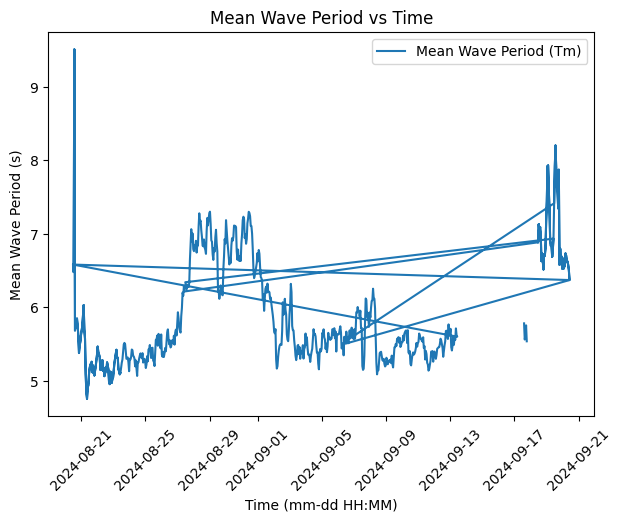

In [20]:
# Plot Mean Wave Period vs Time
plt.plot(waves["Datetime"], waves["MeanPeriod"], label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

**Significant Wave Height**

The mean wave period has units of meters.

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>)

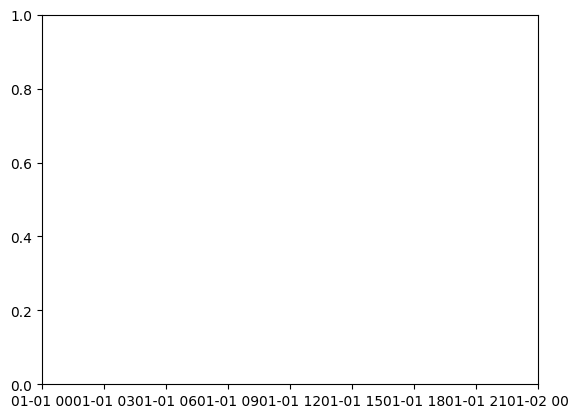

In [23]:
# Plot Mean Wave Period vs Time
plt.scatter(waves["Datetime"], waves["SignificantWaveHeight"], label="Significant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time")
plt.legend()
plt.tight_layout()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

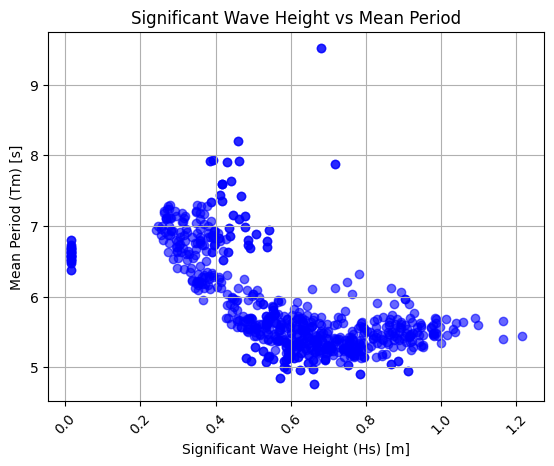

In [25]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
plt.scatter(waves['SignificantWaveHeight'], waves['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Group Wave Speed**

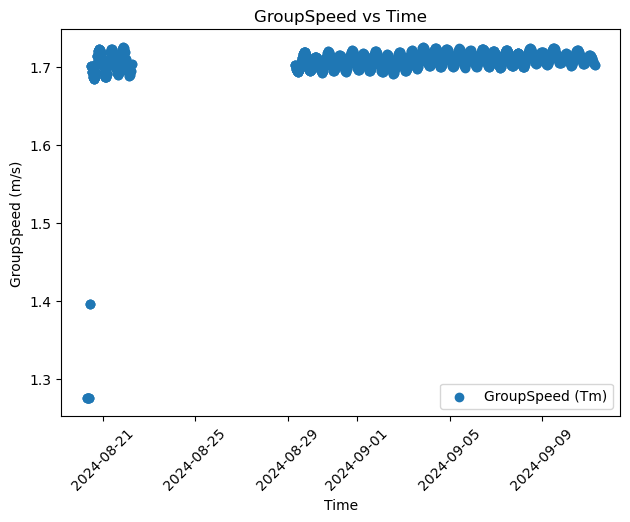

In [ ]:
# Plot Group Wave Speed vs Time
plt.scatter(waves["Datetime"], waves["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time")
plt.legend()
plt.tight_layout()
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

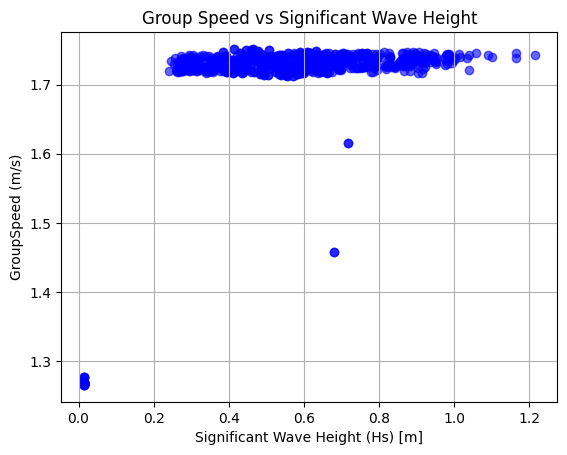

In [26]:
#Look at correlation between wave height and wave group speed
plt.scatter(waves['SignificantWaveHeight'], waves['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)
plt.show()

**Wave Direction and Spread**

The wave direction contains the average direction of wave groups and the spread of this measurement. The direction is measured in degrees from North, i.e. East = 90, South = 180, West = 270, North = 0 or 360. The spread refers to the deviation in degrees that the wave packets may travel in from the mean direction. So a direction of 90 and a spread of 45 means you would expect the wave packets to be traveling on average due east with parts of the wave packet propogating from ENE to ESE.

**Depth Averaged Current Velocity**

The Depth Averaged Current Velocity returns the magnitude 

**Depth Averaged Current Direction**

**Wave Celerity, Wave Number, Frequency Range**

**Data Comparison**

We can compare our data to that collected by the Coastal Ocean Research and Monitoring Program (CORMP). There is SOFAR spotter wave buoy located east of Bald Head Island at 33.8684 N 77.9396 W, and will be denoted at BHI_E. This is further onshore than where our ADCPs were recording data, however will still serve as valid comparison. There is another bouy located just outside of the shoals at 33.721 N 78.015 W, owned by the U.S. Army Corps of Engineers. This buoy is closer to lander S0 and S1, at a water depth of 13 m and will be denoted as USACE_41108.

In [ ]:
# Read in BHI-E Data
BHI_E_path=r"/Volumes/kanarde/BOEM/deployment_1/BulkStats/CORMP_data/data_BHI_E.csv"
BHI_E_data=pd.read_csv(BHI_E_path,skiprows=11)

In [ ]:
# Assign variables for BHI-E buoy
Bdf={}
Bdf["BTime"]=BHI_E_data['Time (America/New_York)']
Bdf["BSigWaveHeight"]=BHI_E_data['BHI-E Significant wave height (m)']
Bdf["BMeanPeriod"]=BHI_E_data['BHI-E Mean wave period (s)']
Bdf["BMeabWaveDirection"]=BHI_E_data['BHI-E Mean wave direction (deg N)']


In [ ]:
# convert to datetime format
Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])

start_date = '2024-08-19'
end_date = '2024-09-20'

# Convert start and end dates to datetime format
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the data based on the date range
filtered_Bdf = {key: value[(Bdf["BTime"] >= start_date) & (Bdf["BTime"] <= end_date)] for key, value in Bdf.items()}

Bdf=filtered_Bdf

In [ ]:
# read in USACE data
USACEpath=r"/Volumes/kanarde/BOEM/deployment_1/BulkStats/CORMP_data/41108h2024.txt"
df = pd.read_csv(USACEpath, delim_whitespace=True, header=1)

In [ ]:
# convert time
df.rename(columns={'#yr': 'yr'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['yr'].astype(str) + '-' +
                                 df['mo'].astype(str).str.zfill(2) + '-' +
                                 df['dy'].astype(str).str.zfill(2) + ' ' +
                                 df['hr'].astype(str).str.zfill(2) + ':' +
                                 df['mn'].astype(str).str.zfill(2))

In [ ]:
# Filter rows based on the date range
filtered_df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
USACEdata=filtered_df
UStime=filtered_df['Datetime']

In [ ]:
# assign variables for USACE buoy
USSigWaveHeight=USACEdata["m"]
USMeanPeriod=USACEdata["sec.1"]
USMeanWaveDirection=USACEdata["degT.1"]

Let's compare our data to that collected during the same time period through the CORMP buoy, starting with mean wave period.

In [ ]:
# Define custom dates for the x-ticks
custom_xticks = [
    "08/20/24","08/24/24", "08/30/24", "09/04/24", "09/09/24", "09/13/24", "09/15/24", "09/19/24"
]
# Convert these dates to datetime format
custom_xticks = pd.to_datetime(custom_xticks, format='%m/%d/%y')

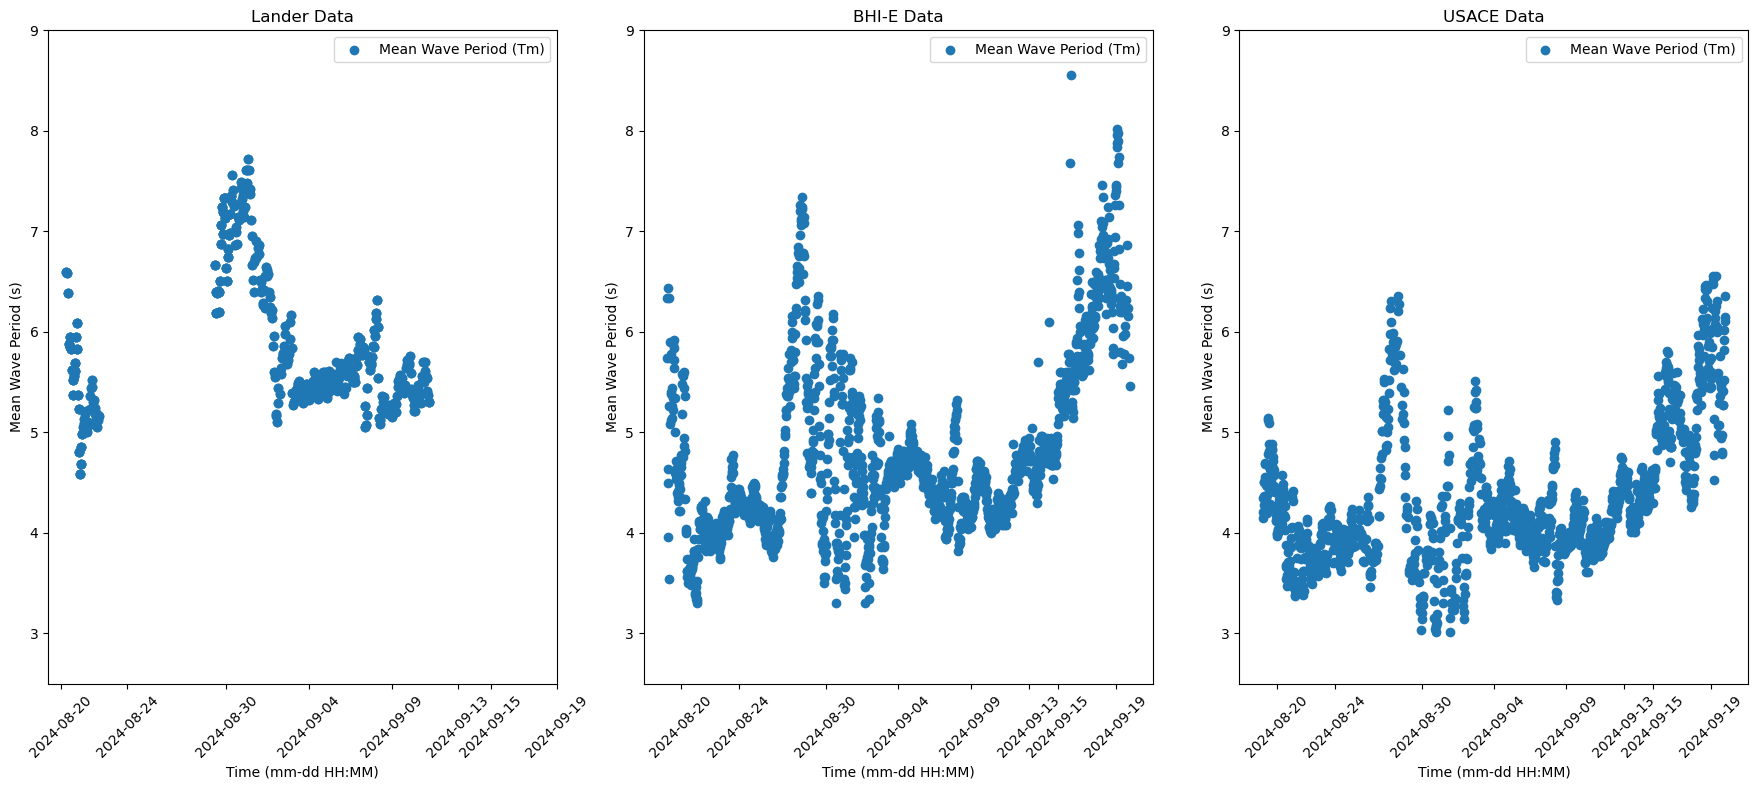

In [ ]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(waves["Datetime"], waves["MeanPeriod"], label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Lander Data")
plt.ylim(2.5,9)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,3,2)
plt.scatter(Bdf["BTime"], Bdf["BMeanPeriod"], label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("BHI-E Data")
plt.ylim(2.5,9)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,3,3)
plt.scatter(UStime, USMeanPeriod, label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("USACE Data")
plt.ylim(2.5,9)
plt.legend()
plt.tight_layout()
plt.xticks(custom_xticks,rotation=45)

plt.show()

Explain differences between plots

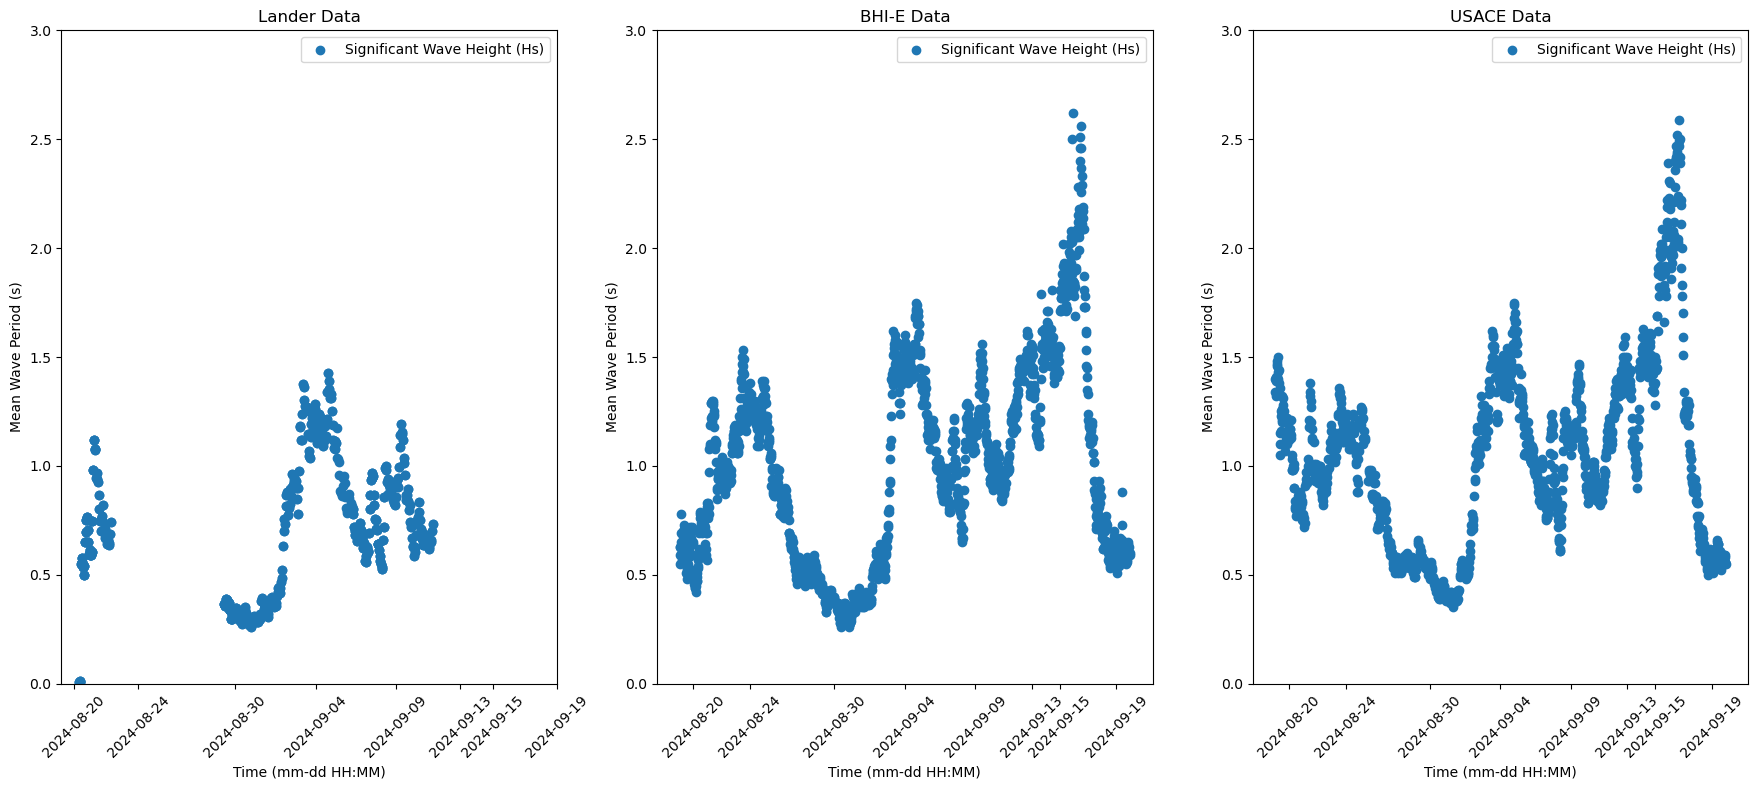

In [ ]:
# Plot Significant Wave Height vs Time
fig=plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(waves["Datetime"], waves["SignificantWaveHeight"], label="Significant Wave Height (Hs)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Lander Data")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,3,2)
plt.scatter(Bdf["BTime"], Bdf["BSigWaveHeight"], label="Significant Wave Height (Hs)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("BHI-E Data")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,3,3)
plt.scatter(UStime, USSigWaveHeight, label="Significant Wave Height (Hs)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("USACE Data")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()
plt.xticks(custom_xticks,rotation=45)


plt.show()

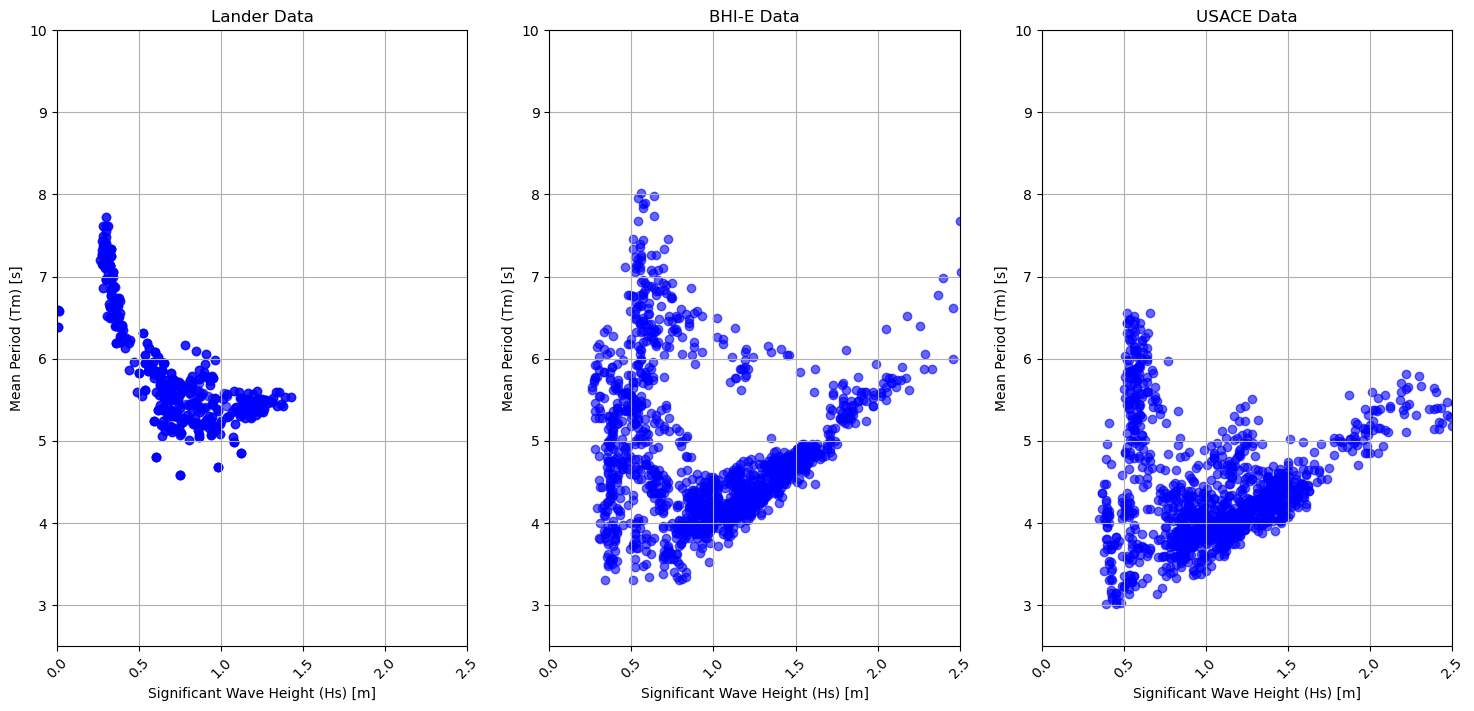

In [ ]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
fig=plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(waves['SignificantWaveHeight'], waves['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Lander Data')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter( Bdf['BSigWaveHeight'],Bdf['BMeanPeriod'], c='blue', alpha=0.6)
plt.title('BHI-E Data')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.grid(True)

plt.subplot(1,3,3)
plt.scatter( USSigWaveHeight,USMeanPeriod, c='blue', alpha=0.6)
plt.title('USACE Data')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.grid(True)

plt.show()